In [10]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models
from torch.autograd import Variable

In [11]:
# setting global parameters
learning_rate = 1e-4
BATCH_SIZE = 32
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# data preprocessing
 
transform_train = transforms.Compose([
   transforms.Resize((224, 224)),  # Resize to 224x224 to match ViT input size
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [13]:
# loading data
dataset_train = datasets.ImageFolder('output2/train', transform_train)
print(dataset_train.imgs)
# label
print(dataset_train.class_to_idx)
dataset_val = datasets.ImageFolder('output2/val', transform_test)

print(dataset_val.class_to_idx)
dataset_test = datasets.ImageFolder('output2/test', transform_test)

print(dataset_test.class_to_idx)
 
# loading data
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

[('output2/train\\Kirmizi_Pistachio\\kirmizi (1).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (10).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (12).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (14).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (15).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (16).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (17).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (18).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (2).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (22).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (23).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (24).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (25).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (26).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (28).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (3).jpg', 0), ('output2/train\\Kirmizi_Pistachio\\kirmizi (30).jpg', 0),

<h1>Vision Transformer</h1>

In [14]:
from timm import create_model

# define Vision Transformer model
class ViTClassifier(nn.Module):
    def __init__(self):
        super(ViTClassifier, self).__init__()
        # loading Vision Transformer 
        self.vit = create_model('vit_base_patch16_224', pretrained=False)
        self.vit.head = nn.Linear(self.vit.head.in_features, 2)  # modify output for binary classification

    def forward(self, x):
        return self.vit(x)

# initial model、loss function and optimizer
model = ViTClassifier().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# train model
def train():
    best_val_acc = 0.0
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        print(f"Epoch {epoch}/{EPOCHS - 1}")
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = Variable(inputs).to(DEVICE), Variable(labels).to(DEVICE)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs.data, 1)
                val_corrects += torch.sum(preds == labels)
                val_total += labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        
        print(f"Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'ViT_best_model-data2.pth')

train()


D:\anaconda3\envs\pytorch_py310\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Epoch 0/29
Loss: 1.0571 Acc: 0.5707
Validation Loss: 0.7160 Validation Acc: 0.4569
Epoch 1/29
Loss: 0.6138 Acc: 0.6561
Validation Loss: 0.4435 Validation Acc: 0.8019
Epoch 2/29
Loss: 0.5045 Acc: 0.7717
Validation Loss: 0.5996 Validation Acc: 0.7016
Epoch 3/29
Loss: 0.4880 Acc: 0.7663
Validation Loss: 0.4698 Validation Acc: 0.7506
Epoch 4/29
Loss: 0.4665 Acc: 0.7679
Validation Loss: 0.4453 Validation Acc: 0.7739
Epoch 5/29
Loss: 0.4649 Acc: 0.7950
Validation Loss: 0.5089 Validation Acc: 0.7110
Epoch 6/29
Loss: 0.5052 Acc: 0.7539
Validation Loss: 0.4407 Validation Acc: 0.7809
Epoch 7/29
Loss: 0.4469 Acc: 0.8059
Validation Loss: 0.4904 Validation Acc: 0.7692
Epoch 8/29
Loss: 0.3963 Acc: 0.8253
Validation Loss: 0.3771 Validation Acc: 0.8182
Epoch 9/29
Loss: 0.4264 Acc: 0.8075
Validation Loss: 0.4102 Validation Acc: 0.8042
Epoch 10/29
Loss: 0.4204 Acc: 0.8005
Validation Loss: 0.4169 Validation Acc: 0.7879
Epoch 11/29
Loss: 0.3980 Acc: 0.8292
Validation Loss: 0.4710 Validation Acc: 0.7786
Ep

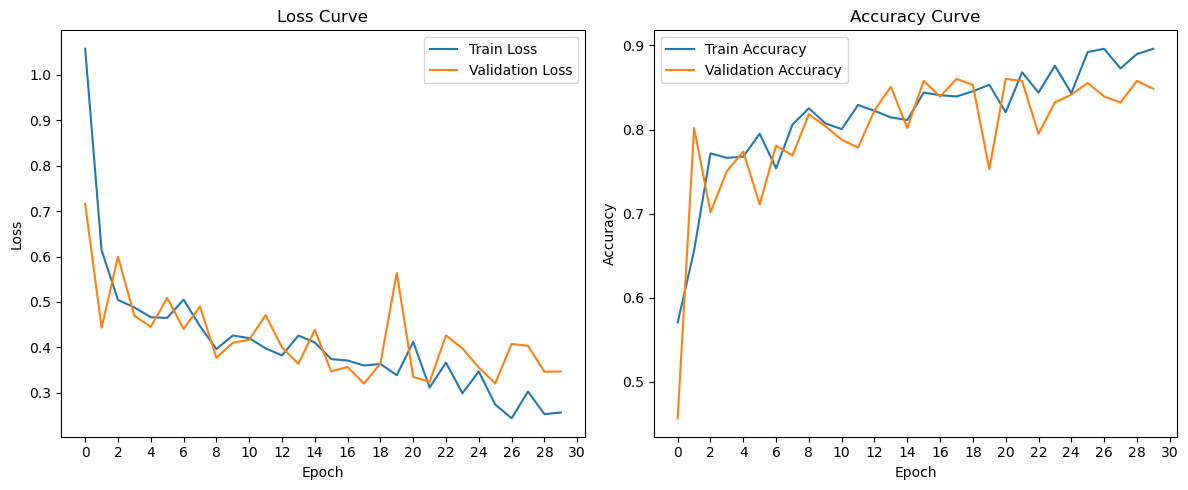

In [7]:
import matplotlib.pyplot as plt
# Plotting the curves
epochs_range = range(EPOCHS)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(0, EPOCHS + 1, 2)) 

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0, EPOCHS + 1, 2)) 
# save
plt.savefig('ViT_train-data2.png', dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()

<h1>Evaluation</h1>

In [8]:
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the best model
model.load_state_dict(torch.load('ViT_best_model-data2.pth'))

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs).to(DEVICE), Variable(labels).to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute and print confusion matrix
conf_matrix = confusion_matrix(np.array(y_true), np.array(y_pred))
print("Confusion Matrix:")
print(conf_matrix)

TP = conf_matrix[0, 0]
TN = conf_matrix[1, 1]
FP = conf_matrix[1, 0]
FN = conf_matrix[0, 1]

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

accuracy = (TP + TN) / (TP + TN + FP + FN)
F1 = 2*TP/(2*TP + FP + FN)
sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"F-1 Score: {F1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity: {specificity:.4f}")

# Save results to DataFrame
filenames = [os.path.basename(x[0]) for x in test_loader.dataset.imgs]
class_indices = test_loader.dataset.class_to_idx
indices = {v: k for k, v in class_indices.items()}

val_df = pd.DataFrame({
    'filename': filenames,
    'actual': [indices[x] for x in y_true],
    'predicted': [indices[x] for x in y_pred]
})
val_df['Same'] = val_df['actual'] == val_df['predicted']
val_df = val_df.sample(frac=1).reset_index(drop=True)

print(val_df.head(10))


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11032\4225004883.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ViT_best_model-da

Confusion Matrix:
[[230  17]
 [ 56 128]]
True Positives (TP): 230
True Negatives (TN): 128
False Positives (FP): 56
False Negatives (FN): 17
Accuracy: 0.8306
F-1 Score: 0.8630
Sensitivity: 0.9312
Precision: 0.8042
Specificity: 0.6957
          filename             actual          predicted   Same
0   kirmizi 16.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio   True
1  kirmizi 719.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio   True
2  kirmizi 196.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio   True
3  kirmizi 505.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio   True
4  kirmizi 243.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio   True
5    siirt 518.jpg    Siirt_Pistachio    Siirt_Pistachio   True
6  kirmizi 222.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio   True
7    siirt 157.jpg    Siirt_Pistachio    Siirt_Pistachio   True
8    siirt 559.jpg    Siirt_Pistachio  Kirmizi_Pistachio  False
9  kirmizi 581.jpg  Kirmizi_Pistachio  Kirmizi_Pistachio   True


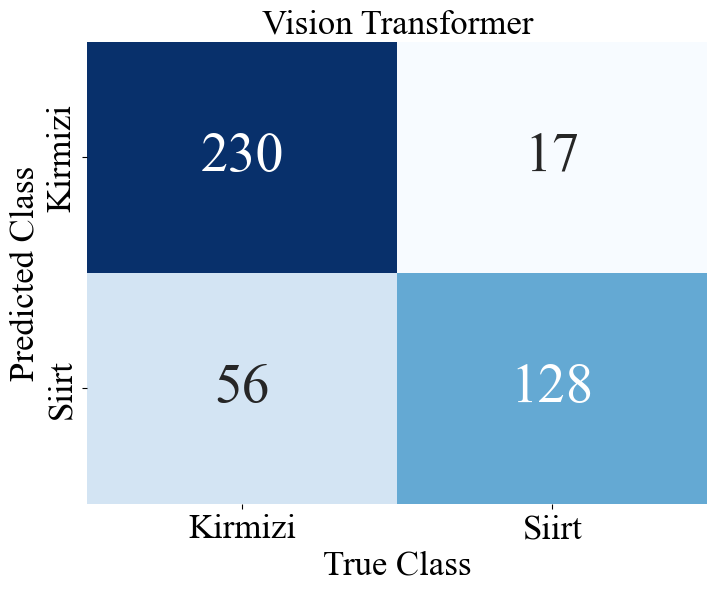

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# set font as Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# plot of confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Kirmizi', 'Siirt'],
            yticklabels=['Kirmizi', 'Siirt'],
            cbar=False, annot_kws={"size": 40})
plt.xlabel('True Class', fontsize=25)
plt.ylabel('Predicted Class', fontsize=25)
plt.title('Vision Transformer', fontsize=25)

ax.tick_params(axis='both', labelsize=25)

# save
plt.savefig('ViT_confusion_matrix-data2.png', dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
import timm
print(timm.list_models())


In [15]:
import pandas as pd
import os
from sklearn.metrics import classification_report
import numpy as np
import torch
from torch.autograd import Variable
import time  # Import time module
from sklearn.metrics import confusion_matrix

# Load the best model
model.load_state_dict(torch.load('ViT_best_model-data2.pth'))

# Evaluation
model.eval()
y_true, y_pred = [], []

# Record the start time
start_time = time.time()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs).to(DEVICE), Variable(labels).to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Record the end time
end_time = time.time()

# Calculate inference time
inference_time = (end_time - start_time) / 217
print(f'Inference Time: {inference_time:.4f} seconds')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11032\345715383.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ViT_best_model-dat

Inference Time: 0.1486 seconds
